# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [1]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

In [15]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'http://www.rit.ac.in/rit-images/mainblock.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

In [70]:
# Image Captioning
#Perform image captioning using finetuned BLIP model

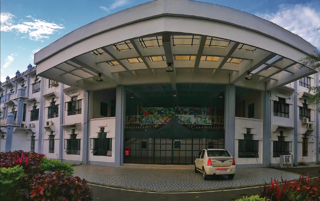

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: the exterior of a hotel in thailand


In [16]:
from models.blip import blip_decoder
#import ruamel_yaml as yaml

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
   # caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

# VQA
# Perform visual question answering using finetuned BLIP model

In [17]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

# url = "https://www.stylecraze.com/wp-content/uploads/2015/07/10-Amazing-Health-Benefits-Of-Playing-Basketball-1.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# training
text = "Front gate of a building?"
label = "Building"
inputs = processor(images=image, text=text, return_tensors="pt")
labels = processor(text=label, return_tensors="pt").input_ids

inputs["labels"] = labels
outputs = model(**inputs)
loss = outputs.loss
loss.backward()

# inference
text = "Is there a car infront of the building?"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))


no


# Feature Extraction

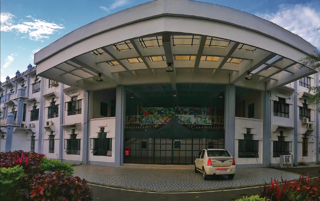

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


In [18]:
from models.blip import blip_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
    
model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = ' the exterior of a hotel in thailand'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# Image-Text Matching

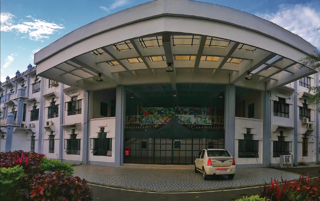

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: a building 
The image and text is matched with a probability of 0.4709
The image feature and text feature has a cosine similarity of 0.3597


In [21]:
from models.blip_itm import blip_itm

image_size = 384
image = load_demo_image(image_size=image_size,device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
    
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cpu')

caption = 'a building '

print('text: %s' %caption)

itm_output = model(image,caption,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,caption,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)